<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tfrecord-만들기" data-toc-modified-id="tfrecord-만들기-1">tfrecord 만들기</a></span><ul class="toc-item"><li><span><a href="#folder-list,-image-list" data-toc-modified-id="folder-list,-image-list-1.1">folder list, image list</a></span></li><li><span><a href="#label-dictionary" data-toc-modified-id="label-dictionary-1.2">label dictionary</a></span></li><li><span><a href="#tfrecord-생성" data-toc-modified-id="tfrecord-생성-1.3">tfrecord 생성</a></span></li><li><span><a href="#decode-확인" data-toc-modified-id="decode-확인-1.4">decode 확인</a></span></li></ul></li></ul></div>

# tfrecord 만들기
## folder list, image list

In [1]:
import os
import glob
import re
import json
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
path = os.getenv("HOME") + "/UDIGO/place_10/*"
folder_list = glob.glob(path)

In [3]:
folder_list

['/home/ssac21/UDIGO/place_10/산',
 '/home/ssac21/UDIGO/place_10/미술관',
 '/home/ssac21/UDIGO/place_10/호텔',
 '/home/ssac21/UDIGO/place_10/아이스링크',
 '/home/ssac21/UDIGO/place_10/아쿠아리움',
 '/home/ssac21/UDIGO/place_10/다리',
 '/home/ssac21/UDIGO/place_10/공원',
 '/home/ssac21/UDIGO/place_10/공항',
 '/home/ssac21/UDIGO/place_10/놀이동산',
 '/home/ssac21/UDIGO/place_10/볼링장']

In [4]:
# 클래스별 데이터 수 맞추기 위해 개수 한정
image_list = [glob.glob(folder + "/*/*")[:500] for folder in folder_list]
len(image_list)

10

In [5]:
# 클래스별로 묶인 2차원 배열을 1차원으로 flatten
import itertools
image_list = list(itertools.chain(*image_list))
len(image_list)

5000

In [6]:
image_list[:10]

['/home/ssac21/UDIGO/place_10/산/mountain/00002591.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00001454.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00000788.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00000085.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00000926.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00004392.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00001125.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00000593.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00004981.jpg',
 '/home/ssac21/UDIGO/place_10/산/mountain/00002729.jpg']

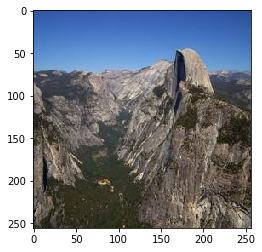

In [7]:
img = cv2.imread(image_list[0], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## label dictionary

In [8]:
label_dict = {}
for index, folder in enumerate(folder_list):
    label = re.sub("[^ㄱ-ㅎ가-힣]", "", folder)
    label_dict[label] = index

In [9]:
label_dict

{'산': 0,
 '미술관': 1,
 '호텔': 2,
 '아이스링크': 3,
 '아쿠아리움': 4,
 '다리': 5,
 '공원': 6,
 '공항': 7,
 '놀이동산': 8,
 '볼링장': 9}

In [10]:
# json 파일로 저장
with open("./data/place_10_label.json", "w") as json_file:
    json.dump(label_dict, json_file)

## tfrecord 생성

In [11]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
tfr_path = "./data/place_10_5000.tfr"

In [13]:
writer = tf.io.TFRecordWriter(tfr_path)
n = 0

for img in image_list:
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # tf record byte로 되어 있음
    image_to_byte = image.tobytes()

    label = re.sub("[^ㄱ-ㅎ가-힣]", "", img)
    label_encoding = label_dict[label]

    example = tf.train.Example(features=tf.train.Features(feature={
        "image" : _bytes_feature(image_to_byte),
        "label" : _int64_feature(label_encoding)
    }))

    writer.write(example.SerializeToString())
    n += 1
writer.close()
print(f"{n}개의 데이터, TFRecord 완성!")

5000개의 데이터, TFRecord 완성!


## decode 확인

In [14]:
dataset = tf.data.TFRecordDataset(tfr_path)

In [15]:
features = {'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64)
           }

In [16]:
def _parse_image(example):
    return tf.io.parse_single_example(example, features)

parsed_dataset = dataset.map(_parse_image)

tf.Tensor(0, shape=(), dtype=int64)


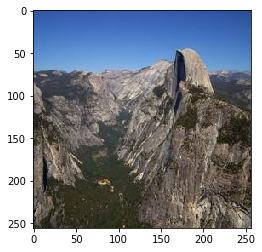

tf.Tensor(0, shape=(), dtype=int64)


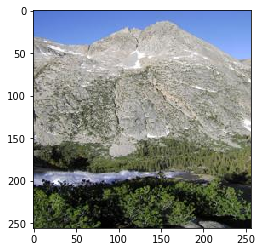

tf.Tensor(0, shape=(), dtype=int64)


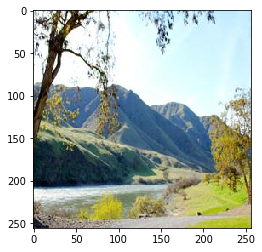

tf.Tensor(0, shape=(), dtype=int64)


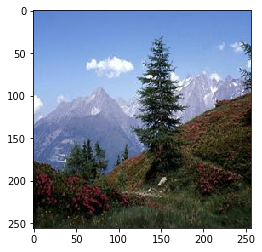

tf.Tensor(0, shape=(), dtype=int64)


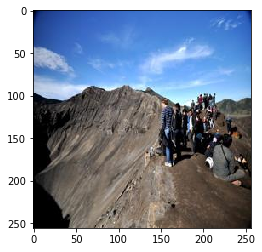

In [17]:
for i_ in parsed_dataset.take(5):
    print(i_['label'])
    image_raw = tf.io.decode_raw(i_['image'], tf.uint8)
    image_raw = tf.reshape(image_raw, [256, 256, 3])
    plt.imshow(image_raw)
    plt.show()